In [ ]:
# Header

In [ ]:
# Data Cleaning

In [ ]:
# Initialize `final` 
import os, sys
import pandas as pd

# allow from src... imports from the notebook folder
sys.path.append(os.path.abspath(".."))

FINAL_PATH = "../data/final_csv.csv"

if os.path.exists(FINAL_PATH):
    final = pd.read_csv(FINAL_PATH)
else:
    from src.data_cleaning import merge_all
    final = merge_all("../data/TeamStatistics copy.csv", "../data/nba-25:26 copy.csv")
    final.to_csv(FINAL_PATH, index=False)

final.head(2)  # sanity check

,Team,Season,Wins,PointDiff,FG%,3P%,FT%,3PAr,FTr,eFG%,TS%,REB,OREB%,DREB%,AST/TOV,TOV%,ORtg,DRtg,NetRtg,PACE
0,76ers,2019-20,NaN,2.215385,46.500614,36.159844,0.745631,0.359937,0.251710,0.530082,0.562425,45.461538,0.227750,0.772250,1.822319,0.140222,108.21281,106.025158,2.187652,101.267692
1,Bucks,2019-20,NaN,11.292308,47.739541,35.577689,0.737769,0.423414,0.263495,0.552716,0.582893,51.723077,0.183522,0.816478,1.738906,0.139079,110.68882,100.153862,10.534958,107.188923


In [1]:
# import module

import sys, os
sys.path.append(os.path.abspath(".."))

# auto-reload src modules when you edit them
%load_ext autoreload
%autoreload 2



In [2]:
# load module
import importlib, src.data_cleaning as dc
importlib.reload(dc)        # not needed if using %autoreload, but fine to keep
from src.data_cleaning import merge_all


In [3]:
# build merge dataset
final = merge_all("../data/TeamStatistics copy.csv", "../data/nba-25:26 copy.csv")

# quick sanity checks
print(final["Season"].value_counts().sort_index())
print(final.groupby("Season")["Team"].nunique().sort_index())
final.head()





Season
2019-20    30
2020-21    30
2021-22    30
2022-23    30
2023-24    30
2024-25    30
2025-26    30
Name: count, dtype: int64
Season
2019-20    30
2020-21    30
2021-22    30
2022-23    30
2023-24    30
2024-25    30
2025-26    30
Name: Team, dtype: int64


/workspaces/Group1-STA4724/src/data_cleaning.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt3 = pd.to_datetime(s[mask], errors="coerce", utc=True, infer_datetime_format=True)


,Team,Season,Wins,PointDiff,FG%,3P%,FT%,3PAr,FTr,eFG%,TS%,REB,OREB%,DREB%,AST/TOV,TOV%,ORtg,DRtg,NetRtg,PACE
0,76ers,2019-20,NaN,2.215385,46.500614,36.159844,0.745631,0.359937,0.251710,0.530082,0.562425,45.461538,0.227750,0.772250,1.822319,0.140222,108.212810,106.025158,2.187652,101.267692
1,Bucks,2019-20,NaN,11.292308,47.739541,35.577689,0.737769,0.423414,0.263495,0.552716,0.582893,51.723077,0.183522,0.816478,1.738906,0.139079,110.688820,100.153862,10.534958,107.188923
2,Bulls,2019-20,NaN,-3.076923,44.654634,34.750219,0.751892,0.396043,0.231170,0.515359,0.547016,41.861538,0.249908,0.750092,1.502488,0.150605,104.074880,107.071997,-2.997117,102.662769
3,Cavaliers,2019-20,NaN,-7.892308,45.826772,35.120773,0.757400,0.362205,0.226772,0.521872,0.552724,44.246154,0.244784,0.755216,1.397950,0.161251,104.414629,112.123999,-7.709370,102.372923
4,Celtics,2019-20,NaN,6.171875,45.928509,36.255708,0.802875,0.381866,0.254752,0.528509,0.566963,45.968750,0.232155,0.767845,1.671249,0.132920,110.112305,104.098151,6.014154,102.622500


In [4]:
# save dataset
final.to_csv("../data/final_csv.csv", index=False)
print("Saved ../data/final_csv.csv")



Saved ../data/final_csv.csv


In [ ]:
# Data cleaning break down
"""
Importing and Exploring the Raw Data

    Loaded two datasets:

    TeamStatistics.csv → contains team-level game data (2019–2025)

    nba-25:26.csv → contains current 2025–26 season data

    Checked structure and columns using df.info() and df.head()

    Verified date range, missing values, and column names

Filtering Relevant Seasons

    Extracted all games from October 22, 2019 up to the most recent game in the dataset

    Used pd.to_datetime() to convert game dates to proper datetime format

    Created a new Season column (e.g., “2019–20”, “2020–21”) based on NBA’s July 1 season boundary

Cleaning & Standardizing Columns

    Stripped extra spaces and fixed inconsistent column names (e.g., "teamName" → "Team", "seasonWins" → "Wins")

    Converted numeric columns to proper data types using pd.to_numeric()

    Removed unnecessary text characters and null values (NaNs)

Creating Key Statistical Variables
    Computed advanced metrics used in modeling:

    Field Goal % (FG%) = FGM / FGA

    3-Point % (3P%) = 3PM / 3PA

    Free Throw % (FT%) = FTM / FTA

    Effective FG% (eFG%) = (FGM + 0.5×3PM) / FGA

    True Shooting % (TS%) = PTS / (2 × (FGA + 0.44×FTA))

    Turnover % (TOV%), Assist/Turnover ratio (AST/TOV)

    Offensive & Defensive Ratings (ORtg, DRtg) and Net Rating

Aggregating by Team and Season

    Grouped by Team and Season using groupby()

    Computed per-game averages and totals for all major stats

    Created one clean row per team per season

Merging Historical + Current Data

    Combined past seasons with the 2025–26 data using pd.concat()

    Dropped duplicate rows for the current season to prevent double counting

    Exported final cleaned file as final_csv.csv to /data/

Final Dataset Overview

    Covers 2019–20 through 2025–26 seasons

    Includes 20+ cleaned, numeric variables

    Ready for Exploratory Data Analysis (EDA) and modeling
"""

In [ ]:
# Basic EDA

In [6]:
# summary

final.select_dtypes(include="number").describe().T



,count,mean,std,min,25%,50%,75%,max
Wins,30.0,41.000000,13.354581,17.000000,34.500000,40.500000,50.000000,68.000000
PointDiff,180.0,-0.222076,4.758920,-12.344828,-3.119520,0.480013,2.849875,11.472727
FG%,210.0,46.575519,1.824618,40.384615,45.626161,46.615426,47.571146,52.661064
3P%,210.0,35.866773,1.902450,27.906977,34.696545,36.009192,36.967215,42.207792
FT%,180.0,0.776791,0.025337,0.696879,0.759440,0.775671,0.794182,0.842243
3PAr,210.0,0.399842,0.042095,0.311107,0.367920,0.393638,0.425542,0.530331
FTr,210.0,0.259969,0.031134,0.199881,0.241725,0.253228,0.270418,0.406312
eFG%,210.0,0.537503,0.021002,0.453297,0.526471,0.536947,0.551551,0.599548
TS%,210.0,0.572979,0.020542,0.500626,0.561101,0.573543,0.585058,0.643180
REB,210.0,44.134462,2.290866,36.000000,42.807692,44.000000,45.431969,51.723077


In [7]:
# quick overview
final.info()
final.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Team       210 non-null    object 
 1   Season     210 non-null    object 
 2   Wins       30 non-null     float64
 3   PointDiff  180 non-null    float64
 4   FG%        210 non-null    float64
 5   3P%        210 non-null    float64
 6   FT%        180 non-null    float64
 7   3PAr       210 non-null    float64
 8   FTr        210 non-null    float64
 9   eFG%       210 non-null    float64
 10  TS%        210 non-null    float64
 11  REB        210 non-null    float64
 12  OREB%      210 non-null    float64
 13  DREB%      210 non-null    float64
 14  AST/TOV    210 non-null    float64
 15  TOV%       210 non-null    float64
 16  ORtg       210 non-null    float64
 17  DRtg       210 non-null    float64
 18  NetRtg     210 non-null    float64
 19  PACE       210 non-null    float64
dtypes: float64

,Team,Season,Wins,PointDiff,FG%,3P%,FT%,3PAr,FTr,eFG%,TS%,REB,OREB%,DREB%,AST/TOV,TOV%,ORtg,DRtg,NetRtg,PACE
0,76ers,2019-20,NaN,2.215385,46.500614,36.159844,0.745631,0.359937,0.251710,0.530082,0.562425,45.461538,0.227750,0.772250,1.822319,0.140222,108.212810,106.025158,2.187652,101.267692
1,Bucks,2019-20,NaN,11.292308,47.739541,35.577689,0.737769,0.423414,0.263495,0.552716,0.582893,51.723077,0.183522,0.816478,1.738906,0.139079,110.688820,100.153862,10.534958,107.188923
2,Bulls,2019-20,NaN,-3.076923,44.654634,34.750219,0.751892,0.396043,0.231170,0.515359,0.547016,41.861538,0.249908,0.750092,1.502488,0.150605,104.074880,107.071997,-2.997117,102.662769
3,Cavaliers,2019-20,NaN,-7.892308,45.826772,35.120773,0.757400,0.362205,0.226772,0.521872,0.552724,44.246154,0.244784,0.755216,1.397950,0.161251,104.414629,112.123999,-7.709370,102.372923
4,Celtics,2019-20,NaN,6.171875,45.928509,36.255708,0.802875,0.381866,0.254752,0.528509,0.566963,45.968750,0.232155,0.767845,1.671249,0.132920,110.112305,104.098151,6.014154,102.622500
5,Clippers,2019-20,NaN,6.515625,46.419237,36.646255,0.793000,0.369925,0.292560,0.531974,0.573964,47.953125,0.228413,0.771587,1.613108,0.140716,110.609333,104.406524,6.202810,105.043125
6,Grizzlies,2019-20,NaN,-1.076923,46.998140,35.165924,0.759508,0.341451,0.234061,0.530019,0.561258,46.707692,0.223650,0.776350,1.771169,0.145136,107.111088,108.135234,-1.024146,105.153231
7,Hawks,2019-20,NaN,-7.970149,44.882149,33.319536,0.788358,0.398220,0.258118,0.515164,0.554171,43.253731,0.228088,0.771912,1.477901,0.151232,104.274590,111.710839,-7.436249,107.179701
8,Heat,2019-20,NaN,3.230769,46.955888,38.322296,0.774354,0.412869,0.297667,0.548669,0.587475,44.538462,0.190674,0.809326,1.744835,0.146212,110.112197,106.940240,3.171956,101.854154
9,Hornets,2019-20,NaN,-6.753846,43.412102,35.186015,0.748646,0.399391,0.251701,0.504386,0.538871,42.784615,0.257102,0.742898,1.632244,0.147391,103.857336,110.675546,-6.818210,99.056000


In [8]:
# numeric summary
num_desc = final.select_dtypes(include="number").describe().T
num_desc


,count,mean,std,min,25%,50%,75%,max
Wins,30.0,41.000000,13.354581,17.000000,34.500000,40.500000,50.000000,68.000000
PointDiff,180.0,-0.222076,4.758920,-12.344828,-3.119520,0.480013,2.849875,11.472727
FG%,210.0,46.575519,1.824618,40.384615,45.626161,46.615426,47.571146,52.661064
3P%,210.0,35.866773,1.902450,27.906977,34.696545,36.009192,36.967215,42.207792
FT%,180.0,0.776791,0.025337,0.696879,0.759440,0.775671,0.794182,0.842243
3PAr,210.0,0.399842,0.042095,0.311107,0.367920,0.393638,0.425542,0.530331
FTr,210.0,0.259969,0.031134,0.199881,0.241725,0.253228,0.270418,0.406312
eFG%,210.0,0.537503,0.021002,0.453297,0.526471,0.536947,0.551551,0.599548
TS%,210.0,0.572979,0.020542,0.500626,0.561101,0.573543,0.585058,0.643180
REB,210.0,44.134462,2.290866,36.000000,42.807692,44.000000,45.431969,51.723077


In [9]:
# check for missing values
final.isna().sum().sort_values(ascending=False)

# some missing games due to current active season

Wins         180
PointDiff     30
FT%           30
Season         0
Team           0
FG%            0
3P%            0
3PAr           0
FTr            0
eFG%           0
TS%            0
REB            0
OREB%          0
DREB%          0
AST/TOV        0
TOV%           0
ORtg           0
DRtg           0
NetRtg         0
PACE           0
dtype: int64

In [10]:
# numeric correlation 
num = final.select_dtypes(include="number")
corr_with_wins = num.corr().loc[:, "Wins"].sort_values(ascending=False)
corr_with_wins


Wins         1.000000
NetRtg       0.976438
PointDiff    0.976425
ORtg         0.874058
TS%          0.715010
eFG%         0.704456
AST/TOV      0.673658
FG%          0.654741
3P%          0.607086
REB          0.234796
FT%          0.229213
DREB%        0.215462
FTr          0.111789
3PAr         0.036374
PACE        -0.112159
OREB%       -0.217858
DRtg        -0.712362
TOV%        -0.721677
Name: Wins, dtype: float64

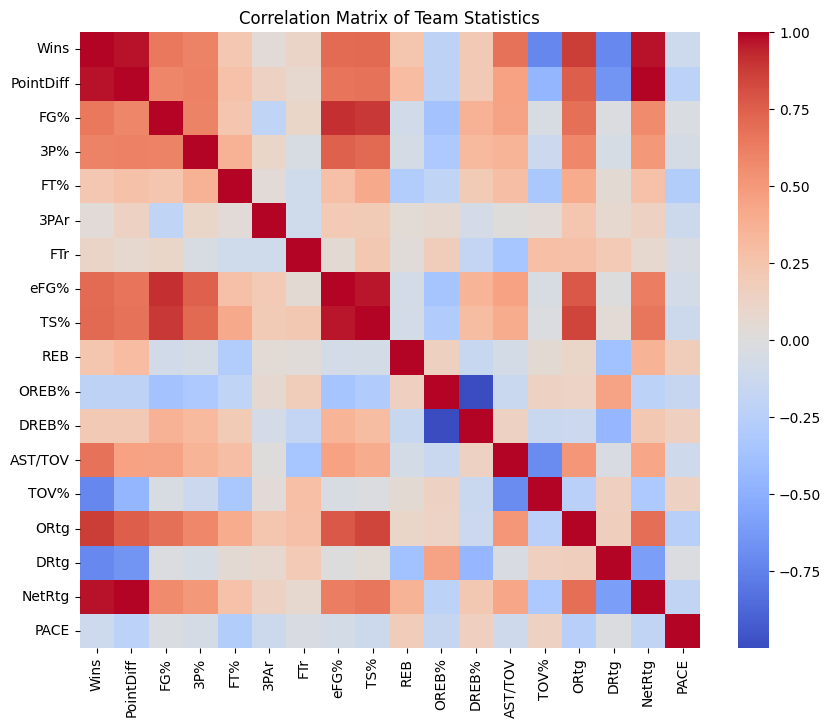

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = final.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Team Statistics")

# save image
plt.savefig("../reports/corr_matrix.png", dpi=300, bbox_inches="tight")
plt.show()


In [6]:
# using a baseline multiple linear regression model to see how much does each stat contribute to a win
# Cell 1 — baseline linear regression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Prepare data
model_data = final.dropna(subset=["Wins"]).copy()
X = model_data.drop(columns=["Wins", "Team", "Season"])
y = model_data["Wins"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train & evaluate
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

# Coefficients (feature influence)
coef = pd.Series(lr.coef_, index=X.columns).sort_values(ascending=False)
coef


R²: 0.5962110112221788
MAE: 5.131272570669675


TOV%         4579.688331
FTr           125.906572
ORtg           29.889536
NetRtg         19.775514
AST/TOV        16.197186
DRtg           10.114021
PACE            4.581362
3P%            -3.821152
PointDiff      -7.815289
REB            -9.273539
FG%           -14.675447
FT%          -102.954488
3PAr         -261.929832
eFG%         -443.722183
DREB%        -664.664404
OREB%       -2842.680821
TS%         -5916.448073
dtype: float64

In [ ]:
# ridge regression

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline

ridge = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=5)
)
ridge.fit(X_train, y_train)

y_pred_r = ridge.predict(X_test)

print("R²:", r2_score(y_test, y_pred_r))
print("MAE:", mean_absolute_error(y_test, y_pred_r))

importance = pd.Series(
    ridge.named_steps['ridgecv'].coef_,
    index=X.columns
).sort_values(ascending=False)
importance


R²: 0.841980057462111
MAE: 3.194638217017069


NetRtg       2.451267
PointDiff    2.449064
ORtg         1.411408
AST/TOV      1.161590
REB          1.046829
FTr          0.951498
TS%          0.749086
FG%          0.743845
eFG%         0.712741
3P%          0.358704
DREB%        0.086613
3PAr         0.070526
FT%          0.041253
OREB%       -0.124642
PACE        -0.406813
TOV%        -1.714629
DRtg        -2.795761
dtype: float64

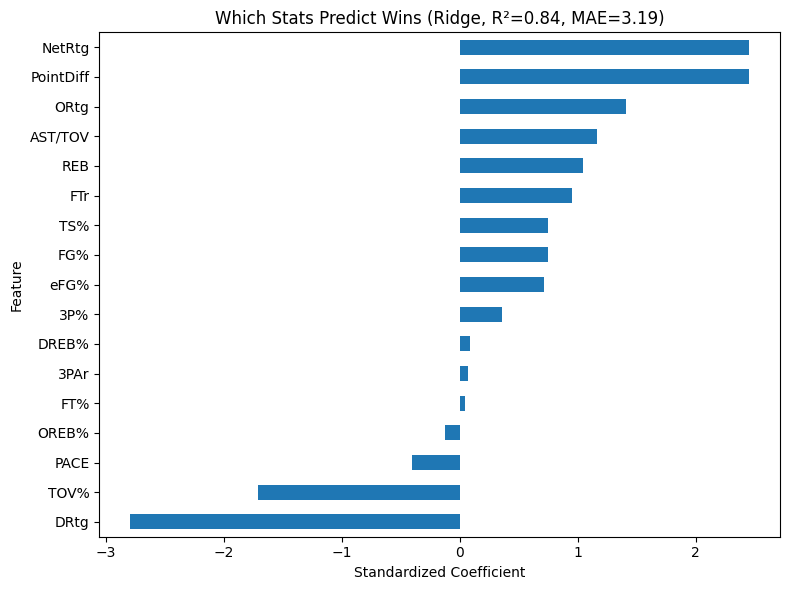

In [ ]:
# feature importance (RidgeCV + scaling)
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_absolute_error

# load the merged data (or re-use `final` if it's already in memory)
final = pd.read_csv("../data/final_csv.csv")

# training set = completed seasons only
model_df = final.dropna(subset=["Wins"]).copy()
X = model_df.drop(columns=["Wins","Team","Season"])
y = model_df["Wins"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ridge = make_pipeline(StandardScaler(), RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=5))
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# standardized coefficients (comparable importance)
imp = pd.Series(ridge.named_steps["ridgecv"].coef_, index=X.columns).sort_values()

plt.figure(figsize=(8,6))
imp.plot(kind="barh")
plt.xlabel("Standardized Coefficient")
plt.ylabel("Feature")
plt.title(f"Which Stats Predict Wins (Ridge, R²={r2:.2f}, MAE={mae:.2f})")
plt.tight_layout()

# save image
plt.savefig("../reports/feature_importance_ridge.png", dpi=150)
plt.show()

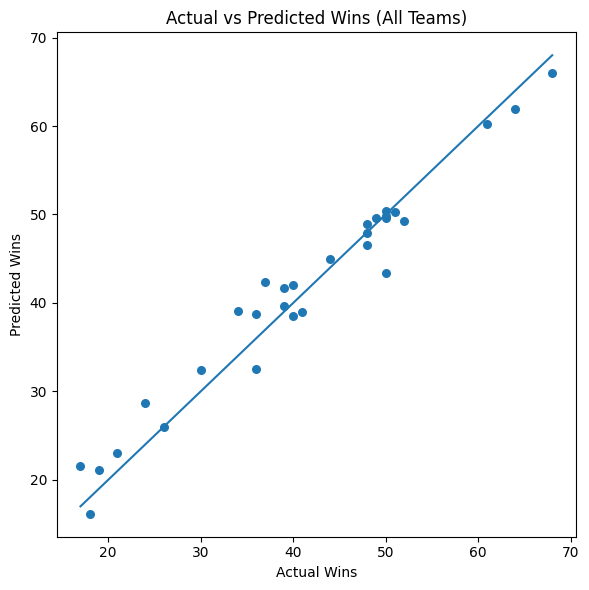

<Figure size 640x480 with 0 Axes>

In [ ]:
# Actual vs Predicted wins
import matplotlib.pyplot as plt
import numpy as np

# visualize how the model performs across the entire dataset
y_all_pred = ridge.predict(X)
plt.figure(figsize=(6,6))
plt.scatter(y, y_all_pred, s=30)
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.xlabel("Actual Wins")
plt.ylabel("Predicted Wins")
plt.title("Actual vs Predicted Wins (All Teams)")
plt.tight_layout()
plt.show()


# save image
plt.savefig("../reports/pred_vs_actual_ridge.png", dpi=150)
plt.show()


In [ ]:
# Next Steps
""""
Descriptive - describe(), histograms, means
Correlation - heatmap, corr with Wins
Relationships - scatterplots, trend lines
Season Trend - groupby season, lineplots
Modeling - R², MAE, coefficient ranking
Visuals - importance bar chart, actual vs predicted
Extras - PCA, clustering, residual plots
Decision Tree to capture nonlinearity
"""